# Notebook to analyze data with interactive graphs

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [20]:
# Get the path to the data folder
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

# Load the csv files created by the process.py script
gdp_data = pd.read_csv(f'{DATA_PATH}/processed/clean_gdp_data.csv').rename(columns = {'value': 'us_gdp'})
spy_data = pd.read_csv(f'{DATA_PATH}/processed/clean_stock_data.csv')[['date', 'adjusted_close']].rename(columns = {'adjusted_close': 'sp500'})

# Format the date columns as datetime and set them as index column
gdp_data['date'] = gdp_data['date'].apply(pd.to_datetime)
gdp_data.set_index('date', inplace=True)
spy_data['date'] = spy_data['date'].apply(pd.to_datetime)
spy_data.set_index('date', inplace=True)

# Join the data and calculate the percentage growths
close_data = gdp_data.join(spy_data).sort_index()
data = close_data.join(close_data.pct_change(1).rename(columns = {'us_gdp': 'us_gdp_growth', 'sp500': 'sp500_growth'})).sort_index()

In [21]:
data

,us_gdp,sp500,us_gdp_growth,sp500_growth
date,,,,
2002-01-01,3263.869,76.9760,NaN,NaN
2002-04-01,3362.508,77.3430,0.030221,0.004768
2002-07-01,3401.820,67.0722,0.011691,-0.132795
2002-10-01,3460.159,55.6833,0.017149,-0.169801
2003-01-01,3340.163,60.3587,-0.034679,0.083964
...,...,...,...,...
2021-04-01,4890.835,387.8659,0.042461,0.063524
2021-07-01,4916.402,420.3074,0.005228,0.083641
2021-10-01,5110.951,422.7312,0.039571,0.005767


In [24]:
# Write a latex label with summary statistics

data_info = data.describe()
data_info.columns = ['US GDP','SPY 500', 'GDP Growth', 'SPY Growth']
data_info=data_info.round(decimals=2)
with open('../reports/tables/summary_statistics.tex','w') as tf:
    tf.write(data_info.to_latex().replace('%', '\%'))
data_info

,US GDP,SPY 500,GDP Growth,SPY Growth
count,82.00,82.00,81.00,81.00
mean,4128.13,160.36,0.01,0.03
std,452.13,101.01,0.03,0.08
min,3263.87,55.68,-0.06,-0.22
25%,3824.75,87.52,-0.02,-0.00
50%,4036.64,112.79,0.02,0.04
75%,4487.54,211.11,0.03,0.07
max,5110.95,469.53,0.08,0.20


In [25]:
# What is the correlation between the two variables

data[['us_gdp', 'sp500']].corr()

,us_gdp,sp500
us_gdp,1.000000,0.908775
sp500,0.908775,1.000000


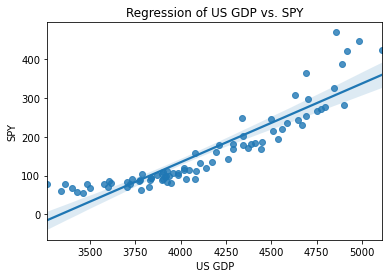

In [12]:
fig = sns.regplot(x=data.us_gdp, y=data.sp500).set(xlabel='US GDP', ylabel='SPY', title='Regression of US GDP vs. SPY');

plt.savefig("../reports/figures/regression.svg")

In [13]:
# Make the two series to start at 100

data_ext = data.copy()

data_ext['us_gdp_100'] = 100*np.exp(np.nan_to_num(data['us_gdp_growth'].cumsum()))
data_ext['sp500_100'] = 100*np.exp(np.nan_to_num(data['sp500_growth'].cumsum()))

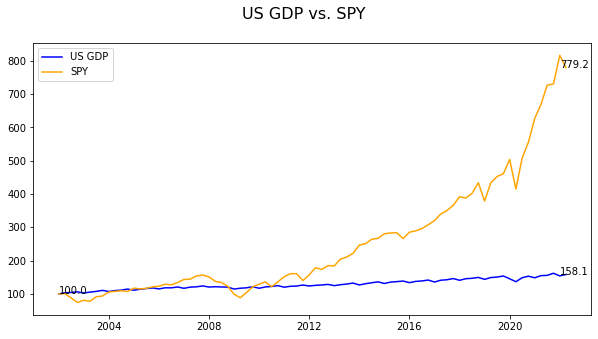

In [14]:
# Plot the two series both starting at 100

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data_ext.us_gdp_100, color='blue')
ax1.plot(data_ext.sp500_100, color='orange')

fig1.suptitle('US GDP vs. SPY', fontsize=16)

ax1.legend(['US GDP', 'SPY'], loc='upper left');

ax1.text(data_ext.us_gdp_100.index[-2], data_ext.us_gdp_100[-1], np.round(data_ext.us_gdp_100[-1], 1))
ax1.text(data_ext.sp500_100.index[-2], data_ext.sp500_100[-1], np.round(data_ext.sp500_100[-1], 1))
ax1.text(data_ext.sp500_100.index[0], data_ext.sp500_100[0], np.round(data_ext.sp500_100[0], 1))

plt.savefig("../reports/figures/growth_starting_at_100.svg")

<ipython-input-19-babc25bccd9e>:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax2.set_xticks([1, 2], ['US GDP', 'S&P 500']);


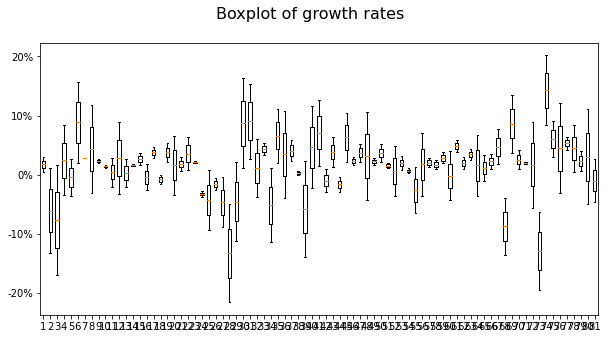

In [19]:
# Add some boxplots

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Boxplot of growth rates', fontsize=16)
ax2.boxplot(data[['us_gdp_growth', 'sp500_growth']].dropna())
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_xticks([1, 2], ['US GDP', 'S&P 500']);

plt.savefig("../reports/figures/boxplots.svg")

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


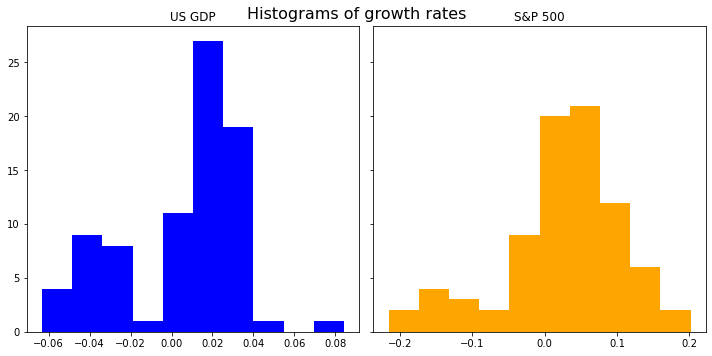

In [16]:
# Add some histograms

fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, tight_layout=True)
fig3.suptitle('Histograms of growth rates', fontsize=16)

ax3[0].set_title('US GDP')
ax3[1].set_title('S&P 500')

ax3[0].hist(data.us_gdp_growth, color = 'blue')
ax3[1].hist(data.sp500_growth, color = 'orange');

plt.savefig("../reports/figures/histograms.svg")

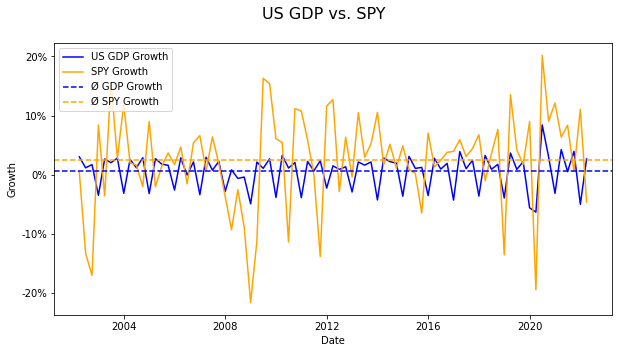

In [17]:
# Plot the growth rates and the average growth over that period

fig4, ax4 = plt.subplots(figsize=(10, 5))

ax4.plot(data.us_gdp_growth, color='blue')
ax4.plot(data.sp500_growth, color='orange')

ax4.axhline(y=np.nanmean(data.us_gdp_growth), color='blue', linestyle='dashed')
ax4.axhline(y=np.nanmean(data.sp500_growth), color='orange', linestyle='dashed')

ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig4.suptitle('US GDP vs. SPY', fontsize=16)
ax4.set_ylabel('Growth')
ax4.set_xlabel('Date')
ax4.legend(['US GDP Growth', 'SPY Growth', 'Ø GDP Growth', 'Ø SPY Growth'], loc='upper left');

plt.savefig("../reports/figures/average_growth.svg")